In [1]:
import numpy as np
import sympy as sp
import matplotlib
import random
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline 
%precision 5

'%.5f'

## Element residual and tangent for the model problem 

The model problem, which is a diffusion problem with posibbly nonlinear source and diffusivity, leads to the following integral that needs to be calculated for every element 

$\int_{\Omega^e} \mathbf{q}\cdot \nabla_x w\,  d\Omega^e + \int_{\Omega^e} s\, w \, d\Omega^e$ 

where $\mathbf{q} = -k(\theta)\nabla_x \theta$ is the flux, which depends on the unknown scalar field $\theta$, and $s(\theta)$ is the source term, which may also depend on the unknown field $\theta$. The weight function is $w$. 

In this notebook, given the nodal values for $\theta$ for a quadrilateral element, as well as working under the assumption that the weight function can also be discretized using nodal quantities, we compute the element residual for a quadrilateral element. Note that the weight function values are never introduced, they are part of the derivation, but because they appear linearly they can be taken out to get an expression of the form 

$\mathbf{w}^e \cdot \mathbf{R}^e$ 

where $\mathbf{w}^e$ are the nodal values of the weighting function which, again, are never assigned a specific value, and $\mathbf{R}^e$ is the residual that we need, which does take a specific value given the nodal values for the discretized field $\theta^h$. The residual, as derived in class, has components 

$R^e_a = \int_{\Omega^e} \mathbf{q}(\theta^h) \cdot \nabla_x N_a^e \, d\Omega^e + \int_{\Omega^e} s(\theta^h) N_a^e \, d\Omega^e$ 

for each node $a=1,2,3,4$. 

For this example, consider 

$k(\theta) = \theta$ 

and 

$s(\theta) = 1/(\theta+1)$ 

In [2]:
# Definition of the shape function and the derivative with respect to parent domain xi

def Nvec(xi,eta):
    return 0.25*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])

def dNvecdxi(xi,eta):
    return 0.25*np.array([[(-1)*(1-eta),(+1)*(1-eta),(+1)*(1+eta),(-1)*(1+eta)],\
                          [(1-xi)*(-1),(1+xi)*(-1),(1+xi)*(+1),(1-xi)*(+1)]])

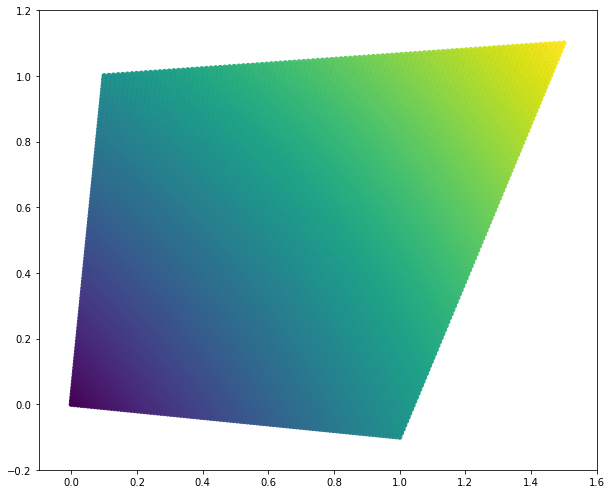

In [14]:
# Define one element and assign nodal values for the field theta_h 
# node coordinates 
x1e = np.array([0.,0.])
x2e = np.array([1.,-0.1])
x3e = np.array([1.5,1.1])
x4e = np.array([0.1,1.])
# nodal values for the field theta
th1e = 0.0
th2e = 1.0
th3e = 2.0
th4e = 1.0

# plot the quadrilateral and color by sampling over the parent domain and scattering
# on the physical domain, not the best solution but will give an idea of the theta field
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim([-0.1, 1.6])
ax.set_ylim([-0.2, 1.2])
ax.set_aspect('equal')
patches = []
colors = np.zeros((1))
polygon = Polygon([x1e,x2e,x3e,x4e], closed=True)
patches.append(polygon)
colors[0] = 0.25*(th1e+th2e+th3e+th4e)
p = PatchCollection(patches)
p.set_array(colors)
ax.add_collection(p)
#plt.colorbar(p,ax=ax,shrink=0.5)

# create a scatter plot by sampling over the parent domain 
theta_vec = np.zeros((10000))
x_vec = np.zeros((10000,2))
for i in range(100):
    for j in range(100):
        xi = -1 + i/99.*2 
        eta = -1 + j/99.*2 
        Ns = Nvec(xi,eta)
        x_vec[i*100+j] = Ns[0]*x1e + Ns[1]*x2e + Ns[2]*x3e + Ns[3]*x4e 
        theta_vec[i*100+j]= Ns[0]*th1e + Ns[1]*th2e + Ns[2]*th3e + Ns[3]*th4e 
ax.scatter(x_vec[:,0],x_vec[:,1],c=theta_vec,s=20)

### Residual 

In [17]:
# To compute the residual, following the class notes 

# integration points (using 2x2 Gauss quadrature in the parent domain)
IP_xi = np.array([[-1./np.sqrt(3),-1./np.sqrt(3)],[+1./np.sqrt(3),-1./np.sqrt(3)],\
                      [+1./np.sqrt(3),+1./np.sqrt(3)],[-1./np.sqrt(3),+1./np.sqrt(3)]])
IP_wi = np.array([1.,1.,1.,1.])

# Initialize the residual to a vector of zeros 
Re = np.zeros((4)) # note the size of the residual is the number of nodes 

for ip in range(4):
    xi  = IP_xi[ip,0]
    eta = IP_xi[ip,1]
    wip = IP_wi[ip]

    # evaluate the isoparametric map 
    Ns = Nvec(xi,eta)
    x = Ns[0]*x1e + Ns[1]*x2e + Ns[2]*x3e + Ns[3]*x4e 

    # evaluate the Jacobian 
    dNsdxi = dNvecdxi(xi,eta)
    dxdxi = np.outer(x1e,dNsdxi[:,0])+np.outer(x2e,dNsdxi[:,1])+np.outer(x3e,dNsdxi[:,2])+np.outer(x4e,dNsdxi[:,3])

    # get gradient of basis function with respect to x using inverse jacobian 
    JinvT = np.linalg.inv(dxdxi).transpose()
    dNsdx = np.dot(JinvT,dNsdxi)
    
    # evaluate the field theta_h at integration point 
    theta = Ns[0]*th1e + Ns[1]*th2e + Ns[2]*th3e + Ns[3]*th4e 
    
    # evaluate the gradient of theta_h with respect to coordinates x 
    gradx_theta = th1e*dNsdx[:,0]+th2e*dNsdx[:,1]+th3e*dNsdx[:,2]+th4e*dNsdx[:,3]
    
    # evaluate the conductivity 
    k = theta 
    
    # evaluate the source 
    s = 1./(1+theta)
    
    # integrate the residual 
    Re[0] +=  wip*np.linalg.det(dxdxi)*(-k*np.dot(gradx_theta,dNsdx[:,0]) + s*Ns[0] )
    Re[1] +=  wip*np.linalg.det(dxdxi)*(-k*np.dot(gradx_theta,dNsdx[:,1]) + s*Ns[1] )
    Re[2] +=  wip*np.linalg.det(dxdxi)*(-k*np.dot(gradx_theta,dNsdx[:,2]) + s*Ns[2] )
    Re[3] +=  wip*np.linalg.det(dxdxi)*(-k*np.dot(gradx_theta,dNsdx[:,3]) + s*Ns[3] )

print('Residual for this element')
print(Re)

Residual for this element
[ 0.89202  0.26837 -0.64753  0.16305]


### Tangent 

The tangent is obtained by first linearizing the residual with respect to an arbitrary increment $\Delta \theta$

$D(\mathbf{R}^e)[\Delta \theta]$ 

and then realizing that the increment has to be also discretized in the same way that the original field, so the increment is actually also of the form 

$\Delta \theta^h = \sum N_i^e \, \Delta \theta_i^e$ 

Plugging the discretization of the increment into the linearization and rearraging the values of the increment at the nodes (since they appear linearly) one finally gets to the tangent 

$\mathbf{K} \cdot \mathbf{\Delta \theta^h}$ 

where the vector $\mathbf{\Delta \theta^h}$ is the vector of nodal increments, and the matrix $\mathbf{K}^e$ is the $4\times 4$ matrix we are looking for. For this example, the components of the tangent are 

$K_{ab}^e = \int_{\Omega^e} \left(-\frac{d \, k(\theta)}{d\, \theta}\, N_b^e \, \nabla_x\theta \cdot \nabla_x N_a^e \right)d\Omega^e + \int_{\Omega^e} -k(\theta) \nabla_x N_b^e \cdot \nabla_x N_a^e d\Omega^e  + \int_{\Omega^e} \left(\frac{d\, s(\theta)}{d\, \theta}\, N_b^e \, N_a^e \right) d\Omega^e $


In [19]:
# integration points (using 2x2 Gauss quadrature in the parent domain)
IP_xi = np.array([[-1./np.sqrt(3),-1./np.sqrt(3)],[+1./np.sqrt(3),-1./np.sqrt(3)],\
                      [+1./np.sqrt(3),+1./np.sqrt(3)],[-1./np.sqrt(3),+1./np.sqrt(3)]])
IP_wi = np.array([1.,1.,1.,1.])

# Initialize the tangent
Ke = np.zeros((4,4))

for ip in range(4):
    xi  = IP_xi[ip,0]
    eta = IP_xi[ip,1]
    wip = IP_wi[ip]

    # evaluate the isoparametric map 
    Ns = Nvec(xi,eta)
    x = Ns[0]*x1e + Ns[1]*x2e + Ns[2]*x3e + Ns[3]*x4e 

    # evaluate the Jacobian 
    dNsdxi = dNvecdxi(xi,eta)
    dxdxi = np.outer(x1e,dNsdxi[:,0])+np.outer(x2e,dNsdxi[:,1])+np.outer(x3e,dNsdxi[:,2])+np.outer(x4e,dNsdxi[:,3])

    # get gradient of basis function with respect to x using inverse jacobian 
    JinvT = np.linalg.inv(dxdxi).transpose()
    dNsdx = np.dot(JinvT,dNsdxi)
    
    # evaluate the field theta_h at integration point 
    theta = Ns[0]*th1e + Ns[1]*th2e + Ns[2]*th3e + Ns[3]*th4e 
    
    # evaluate the gradient of theta_h with respect to coordinates x 
    gradx_theta = th1e*dNsdx[:,0]+th2e*dNsdx[:,1]+th3e*dNsdx[:,2]+th4e*dNsdx[:,3]
    
    # evaluate the conductivity 
    k = theta 
    
    # evaluate the source 
    s = 1./(1+theta)
    
    # evaluate the derivative of the conductivity 
    dkdtheta = 1 
    
    # evaluate the derivative of the source
    dsdtheta = -1./(1+theta)**2
    
    # integrate the tangent, easier to do with for loops 
    for a in range(4):
        for b in range(4):
            Ke[a,b] +=  wip*np.linalg.det(dxdxi)*(-dkdtheta*Ns[b]*np.dot(gradx_theta,dNsdx[:,a])\
                                                  -k*np.dot(dNsdx[:,b],dNsdx[:,a]) + dsdtheta*Ns[a]*Ns[b] )

print('Tangent for this element')
print(Ke)

Tangent for this element
[[-0.26267  0.3162   0.33188  0.36314]
 [ 0.03195 -0.94629  0.28052  0.51423]
 [ 0.07042  0.04566 -0.84753 -0.03995]
 [ 0.04262  0.498    0.16625 -0.92676]]
